# Assignment 7: Convolutional Neural Networks
## Christopher Rico
## MSDS 422

This week, you will compete in the Dogs vs. Cats kernels Edition Kaggle.com competition, https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition 

You will employ at least a 2x2 completely crossed experimental design. We will again use a simple training-and-test regimen. The factors in the design may include numbers of layers and/or nodes within layers, types of layers (convolutional or pooling), and/or other hyperparameters. You will utilize convolutional neural networks (CNNs) within Python TensorFlow.

Specifically, you will build models using the training set to forecast the test set. You are required to submit no fewer than four models for evaluation by Kaggle.com, and you must provide your Kaggle.com scores and user ID for validation. 

TensorFlow Documentation for this assignment:
*   https://www.tensorflow.org/api_docs/python
*   https://www.tensorflow.org/tutorials/index.html

---





# Ingest

### Environment Setup

In [0]:
# import base packages into the namespace for this program
# os interaction
import os
import logging
from google.colab import files

# working with images
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# model quantification
from timeit import default_timer as timer
import numpy as np
import pandas as pd
from IPython.display import display
from statistics import mean

#actual tensorflow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import set_random_seed

# turn off those annoying info logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

### Getting and Examining Data

In [0]:
# Adapted from https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab
# Run this cell and select the kaggle.json file
# To upload the API key

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"christophrico","key":"950c6f1b242d7d9159426efd8bd9cdcb"}'}

In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# now download the images using the kaggle API
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 93% 251M/271M [00:02<00:00, 110MB/s] 
100% 271M/271M [00:02<00:00, 120MB/s]
 99% 540M/544M [00:05<00:00, 99.2MB/s]
100% 544M/544M [00:05<00:00, 113MB/s] 
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 114MB/s]


### Photo Organization

In [0]:
#unzip the jpgs into test and train folders within the root directory
!unzip train.zip -d cats_dogs > /dev/null
!unzip test.zip -d cats_dogs > /dev/null

In [0]:
#make subdirectories in train and validation folders
os.mkdir('/content/cats_dogs/train/cat')
os.mkdir('/content/cats_dogs/train/dog')

os.mkdir('/content/cats_dogs/validation')
os.mkdir('/content/cats_dogs/validation/cat')
os.mkdir('/content/cats_dogs/validation/dog')

In [0]:
# split the images into separate class folders
# this will be important later
train_base = '/content/cats_dogs/train/'
for filename in os.listdir(train_base):
  #get the file's path
  start = os.path.join(train_base, filename)
  if "cat." in filename:
    #create a new path for the file in the cat folder and save
    cat_dest = os.path.join(train_base, 'cat', filename)
    os.rename(start, cat_dest)
  elif "dog." in filename:
    #create a new path for the file in the dog folder and save
    dog_dest = os.path.join(train_base, 'dog', filename)
    os.rename(start, dog_dest)

In [0]:
#now let's drop 10% of the images from the training set into the validation set
validation_base = '/content/cats_dogs/validation/'
#first, the cats
cat_base = os.path.join(train_base, 'cat')
for num, filename in enumerate(os.listdir(cat_base)):
  if num < 1200:
    cat_start = os.path.join(cat_base, filename)
    cat_dest = os.path.join(validation_base, 'cat', filename)
    os.rename(cat_start, cat_dest)
  else:
    break

In [0]:
#then, the dogs
dog_base = os.path.join(train_base, 'dog')
for num, filename in enumerate(os.listdir(dog_base)):
  if num < 1200:
    dog_start = os.path.join(dog_base, filename)
    dog_dest = os.path.join(validation_base, 'dog', filename)
    os.rename(dog_start, dog_dest)
  else:
    break

In [0]:
#let's save the filepath to each of the train, test, and val
train_dir = '/content/cats_dogs/train/'
validation_dir = '/content/cats_dogs/validation/'
testing_dir = '/content/cats_dogs/test'

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cat')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dog')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cat')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dog')


In [0]:
#and then see how many photos are in each
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total testing images:', len(os.listdir(testing_dir)))

total training cat images: 11300
total training dog images: 11300
total validation cat images: 1200
total validation dog images: 1200
total testing images: 12500


# EDA


---



Let's take a look at a few pictures of the cats and dogs to get a better idea of what each looks like.

Adapted from https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=0oj0gTIy4k60

In [0]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

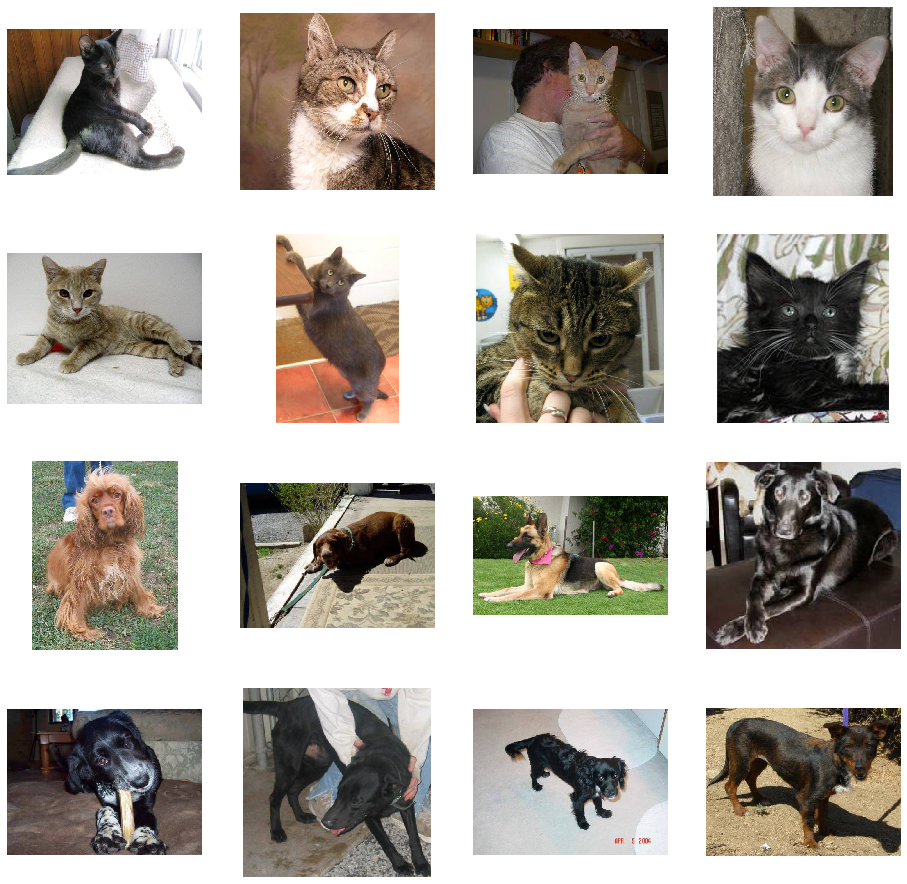

In [0]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Modeling


---



### Utility Functions

Output predictions

In [0]:
# output predictions to kaggle-formatted csv
def pred_output(filename, preds):
  #create the output files
  rf_out = open(filename, "w")
  rf_out.write("ImageId,Label\n")

  #save the predictions to it
  index = 1
  for prediction in preds:
    rf_out.write( "{},{}\n".format(index, prediction[0]) )
    index += 1

  #close the filestream
  rf_out.close()


Model Training, Prediction, and Evaluation Utility Function

In [0]:
#run training, predictingm evaluation
def model_eval(models, train_gen, val_gen, X_test):

  results = pd.DataFrame(columns=[
                                'Name',
                                'Processing Time',
                                'Training Set Accuracy',
                                ])
  
  for name, model in models:
    #compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.0002),
                  metrics=['acc']
                  )
      
    #fit the model
    start = timer()
    history = model.fit_generator(
                                  train_gen,
                                  steps_per_epoch=100,  # 2000 images = batch_size * steps
                                  epochs=20,
                                  validation_data=val_gen,
                                  validation_steps=50,  # 1000 images = batch_size * steps
                                  verbose=1
                                )
    end = timer()
    train_time = "{:.2f}".format(end-start)
    
    #make predictions
    #predicts = model.predict(X_test)


    # Retrieve a list of accuracy results on training and validation data
    # sets for each training epoch
    acc = history.history['acc']
    avg_acc = "{:.5f}".format(mean(acc))
    val_acc = history.history['val_acc']


    # Retrieve a list of list results on training and validation data
    # sets for each training epoch
    loss = history.history['loss']
    avg_loss = "{:.5f}".format(mean(loss))
    val_loss = history.history['val_loss']
    # Get number of epochs
    epochs = range(len(acc))


    #print out a summary and perform evaluations
    print("#___________ Summary of Model {} ___________#".format(name))
    model.summary()
    print("Training time: {}".format(train_time))
    print("Training Accuracy: {}".format(avg_acc))
    print("Training Loss: {}".format(avg_loss))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')

    plt.figure()
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
  
    print("__________________________________________")

    """
    output_name = "{}.csv".format(name)
    #create an output CSV to be downloaded
    pred_output(output_name, predicts)
    """

    #append the results to the dataframe
    results = results.append({
                          'Name' : name,
                          'Processing Time' : train_time,
                          'Training Set Loss': avg_loss,
                          },
                          sort = False,
                          ignore_index=True
                         )  
  # end loop

  # return the results df
  return results



### Data Preprocessing

This is where we get all the image data in to a usable format for a CNN

In [0]:
# All images will be rescaled by 1./255
# We will augment the training image dataset to boost accuracy
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True
                                  )
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  
                                                    target_size=(200, 200),
                                                    batch_size=32,
                                                    class_mode='binary'
                                                   )

val_datagen = ImageDataGenerator(rescale=1./255)
# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
                                                       validation_dir,
                                                       target_size=(200, 200),
                                                       batch_size=32,
                                                       class_mode='binary'
                                                       )

Found 22600 images belonging to 2 classes.
Found 2400 images belonging to 2 classes.


In [0]:
#now we flow the test image data out in batches of 20
datagen = ImageDataGenerator(rescale=1./255)
test_data = datagen.flow_from_directory(
                                        '/content/cats_dogs',
                                        classes=['test'],
                                        target_size=(200, 200),
                                        batch_size=30
                                       )

Found 12500 images belonging to 1 classes.


### Model 1: D_3C

*   3 Convolutional Layers (32, 64, 128) sandwiched with 3 Max-pooling layers
*   2 Fully Connected Layers w/256 hidden units each
*   Dropout of 0.5




In [0]:
# Our input feature map is 200x200x3: 200x200 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input1 = layers.Input(shape=(200, 200, 3))

# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input1)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create 2 fully connected layers with ReLU activation and 256 hidden units
# Add a dropout rate of 0.5 between each
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output1 = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
D_3C = Model(img_input1, output1)

### Model 2: ND_3C

*   3 Convolutional Layers (32, 64, 128) sandwiched with 3 Max-pooling layers
*   2 Fully Connected Layers w/256 hidden units each
*   No Dropout


In [0]:
# Our input feature map is 200x200x3: 200x200 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input2 = layers.Input(shape=(200, 200, 3))

# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input2)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create 2 fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output2 = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
ND_3C = Model(img_input2, output2)

### Model 3: D_4C

*   4 Convolutional Layers (32, 64, 128, 256) sandwiched with 4 Max-pooling layers
*   2 Fully Connected Layers w/256 hidden units each
*   Dropout of 0.5

In [0]:
# Our input feature map is 200x200x3: 200x200 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input3 = layers.Input(shape=(200, 200, 3))

# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input3)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Fourth convolution extracts 256 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create 2 fully connected layers with ReLU activation and 256 hidden units
# Add a dropout rate of 0.5 between each
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output3 = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
D_4C = Model(img_input3, output3)

### Model 4: ND_4C

*   4 Convolutional Layers (32, 64, 128, 256) sandwiched with 4 Max-pooling layers
*   2 Fully Connected Layers w/256 hidden units each
*   No Dropout

In [0]:
# Our input feature map is 200x200x3: 200x200 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input4 = layers.Input(shape=(200, 200, 3))

# First convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(img_input4)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 128 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Fourth convolution extracts 256 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create 2 fully connected layers with ReLU activation and 512 hidden units
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output4 = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
ND_4C = Model(img_input4, output4)

### Model Evaluation

Epoch 1/20
100/100 [==============================] - 56s 556ms/step - loss: 0.6943 - acc: 0.5406 - val_loss: 0.6864 - val_acc: 0.5906
Epoch 2/20
100/100 [==============================] - 51s 511ms/step - loss: 0.6615 - acc: 0.6044 - val_loss: 0.6319 - val_acc: 0.6269
Epoch 3/20
100/100 [==============================] - 53s 528ms/step - loss: 0.6218 - acc: 0.6597 - val_loss: 0.5819 - val_acc: 0.6875
Epoch 4/20
100/100 [==============================] - 52s 518ms/step - loss: 0.6110 - acc: 0.6700 - val_loss: 0.5591 - val_acc: 0.7237
Epoch 5/20
100/100 [==============================] - 51s 513ms/step - loss: 0.5664 - acc: 0.7110 - val_loss: 0.5409 - val_acc: 0.7262
Epoch 6/20
100/100 [==============================] - 52s 521ms/step - loss: 0.5567 - acc: 0.7237 - val_loss: 0.5295 - val_acc: 0.7375
Epoch 7/20
100/100 [==============================] - 52s 524ms/step - loss: 0.5486 - acc: 0.7275 - val_loss: 0.5059 - val_acc: 0.7625
Epoch 8/20
100/100 [==============================] - 5

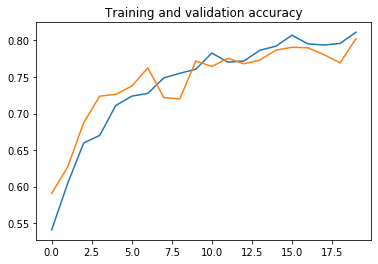

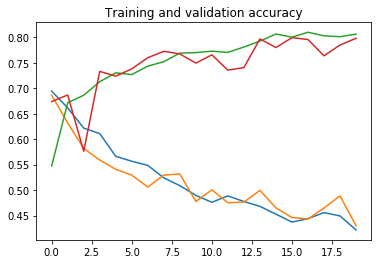

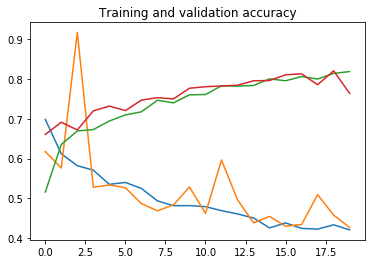

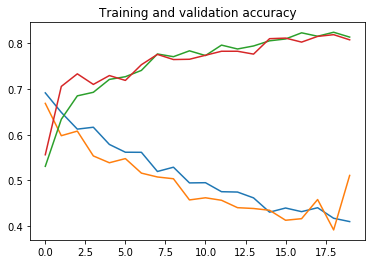

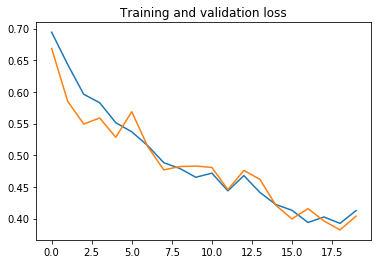

In [0]:
# save all the instantiated models in tuples, for pretty printing
CNN_models = [
              ('D_3C', D_3C),
              ('ND_3C', ND_3C),
              ('D_4C', D_4C),
              ('ND_4C', ND_4C)
             ]

#run the evaluation
results_df = model_eval(
                        models = CNN_models,
                        train_gen = train_generator,
                        val_gen = validation_generator,
                        X_test = test_data
                       )

In [0]:
#download the csvs with predictions
files.download("D_3C.csv")
files.download("ND_3C.csv")
files.download("D_4C.csv")
files.download("ND_4C.csv")

In [0]:
#add in results from kaggle and variable values
results_df['Convolutional Layers'] = [3, 3, 4, 4]
results_df['Dropout'] = ['Yes', 'No', 'Yes', 'No']
results_df['Test Set Loss'] = [1.21871, 1.35034, 1.43362, 1.46427]

#rearrange the columns for pretty printing
results_df = results_df[['Convolutional Layers',
                        'Dropout',
                        'Processing Time',
                        'Training Set Loss',
                        'Test Set Loss']]

#and display em
display(results_df)

,Convolutional Layers,Dropout,Processing Time,Training Set Loss,Test Set Loss
0,3,Yes,1042.92,0.51773,1.21871
1,3,No,1037.19,0.49702,1.35034
2,4,Yes,1060.15,0.51461,1.43362
3,4,No,1071.95,0.49070,1.46427


# Conclusion


---



While speed and accuracy results are similar across NN topologies, recommend the CNN with 3 convolutional layers and a dropout layer with rate of 0.5. 